In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
%cd drive/My\ Drive/Project/PlantDiseaseDetector

/content/drive/My Drive/Project/PlantDiseaseDetector


In [22]:
# !mkdir radam
# %cd radam

/content/drive/My Drive/Project/PlantDiseaseDetector/radam


In [2]:
try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [0]:
#Load data
zip_file=tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
 fname='PlantVillage.zip', extract=True)

In [0]:
#Create the training and validation directories
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [6]:
!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;
import json
with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

--2020-01-17 00:17:07--  https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/obeshor/Plant-Diseases-Detector/zip/master [following]
--2020-01-17 00:17:08--  https://codeload.github.com/obeshor/Plant-Diseases-Detector/zip/master
Resolving codeload.github.com (codeload.github.com)... 13.229.189.0
Connecting to codeload.github.com (codeload.github.com)|13.229.189.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ]   2.25M  12.1MB/s    in 0.2s    

2020-01-17 00:17:08 (12.1 MB/s) - ‘master.zip’ saved [2358172]

Archive:  master.zip
59c418921242879a6aa5378175076bf7f39a84fe
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Disease

In [0]:
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [0]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 64 #@param {type:"integer"}

In [0]:
module_selection

('inception_v3', 299, 2048)

In [8]:
# Inputs are suitably resized for the selected module.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.


In [0]:
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 43444 images belonging to 38 classes.


In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [0]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in feature_extractor.layers[-30:]:
      layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [1]:
# This section we need to use Rectified Adam
!pip install keras-rectified-adam

In [0]:
from keras_radam.training import RAdamOptimizer
opt = RAdamOptimizer(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5)

In [0]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [0]:
model.summary()

In [0]:
#Compile model specifying the optimizer learning rate
LEARNING_RATE = 0.001
model.compile(
    # optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [23]:
!mkdir training
!ls

master.zip  Plant-Diseases-Detector-master  training


In [24]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

In [0]:
print("train_generator.samples", train_generator.samples, ":", train_generator.batch_size, "train_generator.batch_size")
print("Hasil", train_generator.samples//train_generator.batch_size)
print("validation_generator.samples", validation_generator.samples, ":", validation_generator.batch_size, "validation_generator.batch_size")
print("Hasil", validation_generator.samples//validation_generator.batch_size)

train_generator.samples 43444 : 64 train_generator.batch_size
Hasil 678
validation_generator.samples 10861 : 64 validation_generator.batch_size
Hasil 169


In [25]:
EPOCHS=10
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit_generator( 
          train_generator,
          steps_per_epoch=STEPS_EPOCHS,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS)

Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


Train for 678 steps, validate for 169 steps
Epoch 1/10
Train for 678 steps, validate for 169 steps
Epoch 1/10
Train for 678 steps, validate for 169 steps
Epoch 1/10
Train for 678 steps, validate for 169 steps
Epoch 1/10
Train for 678 steps, validate for 169 steps
Epoch 1/10
Train for 678 steps, validate for 169 steps
Epoch 1/10
678/678 [==============================] - 884s 1s/step - loss: 1.5702 - accuracy: 0.5956 - val_loss: 0.5620 - val_accuracy: 0.8266
Epoch 2/10
Epoch 2/10
Epoch 2/10
Epoch 2/10
Epoch 2/10
Epoch 2/10
678/678 [==============================] - 857s 1s/step - loss: 0.4580 - accuracy: 0.8566 - val_loss: 0.3989 - val_accuracy: 0.8738
Epoch 3/10
Epoch 3/10
Epoch 3/10
Epoch 3/10
Epoch 3/10
Epoch 3/10
678/678 [==============================] - 857s 1s/step - loss: 0.3491 - accuracy: 0.8889 - val_loss: 0.3247 - val_accuracy: 0.8977
Epoch 4/10
Epoch 4/10
Epoch 4/10
Epoch 4/10
Epoch 4/10
Epoch 4/10
678/678 [==============================] - 859s 1s/step - loss: 0.3005 - acc

Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 678 steps, validate for 169 steps
Epoch 1/10
678/678 [==============================] - 884s 1s/step - loss: 1.5702 - accuracy: 0.5956 - val_loss: 0.5620 - val_accuracy: 0.8266
Epoch 2/10
678/678 [==============================] - 857s 1s/step - loss: 0.4580 - accuracy: 0.8566 - val_loss: 0.3989 - val_accuracy: 0.8738
Epoch 3/10
678/678 [==============================] - 857s 1s/step - loss: 0.3491 - accuracy: 0.8889 - val_loss: 0.3247 - val_accuracy: 0.8977
Epoch 4/10
678/678 [==============================] - 859s 1s/step - loss: 0.3005 - accuracy: 0.9028 - val_loss: 0.2620 - val_accuracy: 0.9129
Epoch 5/10
678/678 [==============================] - 855s 1s/step - loss: 0.2591 - accuracy: 0.9162 - val_loss: 0.2327 - val_accuracy: 0.9254
Epoch 6/10
678/678 [==============================] - 855s 1s/step - loss: 0.2305 - accuracy: 0.9254 - val_loss: 0.2258 - val_accuracy: 0.9280
Epoch 7/10
678/678 [==============================] - 867s 1s/step - loss: 0.2022 - accuracy: 0.93

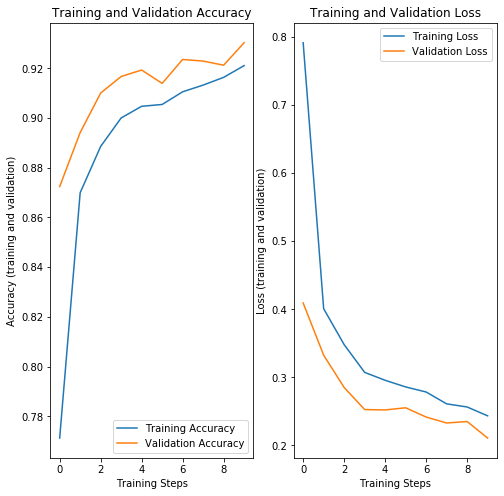

In [0]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [0]:
# Import OpenCV
import cv2
# Utility
import itertools
import random
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img
def predict(image):
    probabilities = new_model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

### Inference

In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob
import numpy as np
import sys


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    print(filename, ":", img)
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    print("resized:", img)
    img = img /255
    print("Normalized",img)
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    print("After Softmax", probabilities)
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [0]:
if any("c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG" in s for s in validation_generator.filenames):
  print(True)
matching = [s for s in validation_generator.filepaths if "c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG" in s]
print(matching)

True
['/root/.keras/datasets/PlantVillage/validation/Blueberry___healthy/c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG']


In [0]:
np.set_printoptions(threshold=sys.maxsize)

In [0]:
img = cv2.imread('/root/.keras/datasets/PlantVillage/validation/Blueberry___healthy/c0c3498a-4b3c-49b0-b44f-2b3f0d7a6ebb___RS_HL 2372.JPG')
# print(img)

In [0]:
img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
img

In [0]:
img = img / 255
img

In [0]:
new_model.predict(np.asarray([img]))[0]

array([4.6510851e-07, 2.2118666e-08, 7.2860371e-09, 2.5625669e-03,
       9.9740797e-01, 4.0713604e-07, 6.0860458e-07, 1.8846893e-11,
       2.4848626e-12, 3.5132546e-11, 2.0301982e-09, 1.5751841e-09,
       6.1362911e-12, 2.5331942e-13, 2.5936744e-12, 4.9445212e-08,
       1.1052828e-09, 1.2400291e-10, 1.1722995e-10, 2.8861045e-09,
       2.2245803e-12, 4.9718119e-07, 4.3223460e-07, 5.1047064e-09,
       2.2830574e-05, 5.6818165e-11, 4.2907910e-11, 1.7561041e-07,
       7.1636391e-10, 6.8038450e-09, 2.9787718e-06, 2.9060745e-08,
       2.4517002e-09, 4.8934942e-07, 3.7937795e-08, 7.4077233e-09,
       2.7334131e-11, 4.8361602e-07], dtype=float32)

In [0]:
class_idx = np.argmax(new_model.predict(np.asarray([img]))[0])

In [0]:
class_idx

4

In [0]:
IMAGE_SHAPE = (299, 299)
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [0]:
cv2.__version__

'4.1.2'

In [0]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(new_model, export_path)

export_path

In [0]:
reloaded = tf.keras.experimental.load_from_saved_model("checkpoint")

In [0]:
new_model = tf.keras.models.load_model("checkpoint")

In [0]:
new_model.predict()

In [0]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"

In [0]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : new_model(x))

In [0]:
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(new_model.inputs[0].shape, new_model.inputs[0].dtype)
)

In [0]:
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

In [0]:
tf.__version__

In [0]:
!mkdir training_1_15
!ls

In [0]:
import datetime
filename = "test_{}.hdf5".format(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model.save("training_1_15", save_format='tf')